(Multi-output-GPs_Coregion)=
# Multi-output Gaussian Processes: Coregionalization models using Hamadard product

:::{post} October, 2022
:tags: gaussian process, multi-output
:category: intermediate
:author: Danh Phan, Bill Engels, Chris Fonnesbeck
:::

This notebook shows how to implement the **Intrinsic Coregionalization Model** (ICM) and the **Linear Coregionalization Model** (LCM) using a Hamadard product between the Coregion kernel and input kernels. Multi-output Gaussian Process is discussed in [this paper](https://papers.nips.cc/paper/2007/hash/66368270ffd51418ec58bd793f2d9b1b-Abstract.html) by {cite:t}`bonilla2007multioutput`. For further information about ICM and LCM, please check out the [talk](https://www.youtube.com/watch?v=ttgUJtVJthA&list=PLpTp0l_CVmgwyAthrUmmdIFiunV1VvicM) on Multi-output Gaussian Processes by Mauricio Alvarez, and [his slides](http://gpss.cc/gpss17/slides/multipleOutputGPs.pdf) with more references at the last page.

The advantage of Multi-output Gaussian Processes is their capacity to simultaneously learn and infer many outputs which have the same source of uncertainty from inputs. In this example, we model the average spin rates of several pitchers in different games from a baseball dataset.

In [35]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from pymc.gp.util import plot_gp_dist

In [36]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

## Preparing the data
The baseball dataset contains the average spin rate of several pitchers on different game dates.

In [37]:
# get data
try:
    df = pd.read_csv("../data/fastball_spin_rates.csv")
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("fastball_spin_rates.csv"))

print(df.shape)
df.head()

In [38]:
print(
    f"There are {df['pitcher_name'].nunique()} pitchers, in {df['game_date'].nunique()} game dates"
)

There are 262 pitchers, in 182 game dates


In [39]:
# Standardise average spin rate
df["avg_spin_rate"] = (df["avg_spin_rate"] - df["avg_spin_rate"].mean()) / df["avg_spin_rate"].std()
df["avg_spin_rate"].describe()

count    4.838000e+03
mean    -1.174936e-17
std      1.000000e+00
min     -3.646438e+00
25%     -6.803556e-01
50%      4.736011e-03
75%      6.837128e-01
max      3.752720e+00
Name: avg_spin_rate, dtype: float64

#### Top N popular pitchers

In [40]:
# Get top N popular pitchers by who attended most games
n_outputs = 5  # Top 5 popular pitchers
top_pitchers = df.groupby("pitcher_name")["game_date"].count().nlargest(n_outputs).reset_index()
top_pitchers = top_pitchers.reset_index().rename(columns={"index": "output_idx"})
top_pitchers

,output_idx,pitcher_name,game_date
0,0,"Rodriguez, Richard",64
1,1,"Taylor, Josh",59
2,2,"Kopech, Michael",43
3,3,"Wells, Tyler",43
4,4,"Hearn, Taylor",42


In [41]:
# Filter the data with only top N pitchers
adf = df.loc[df["pitcher_name"].isin(top_pitchers["pitcher_name"])].copy()
print(adf.shape)
adf

(251, 4)


,pitcher_name,game_date,avg_spin_rate,n_pitches
1631,"Rodriguez, Richard",2021-04-01,1.245044,12
1632,"Rodriguez, Richard",2021-04-06,2.032285,3
1633,"Rodriguez, Richard",2021-04-08,1.868068,10
1634,"Rodriguez, Richard",2021-04-12,1.801864,14
1635,"Rodriguez, Richard",2021-04-13,1.916592,9
...,...,...,...,...
4539,"Wells, Tyler",2021-09-15,1.022205,12
4540,"Wells, Tyler",2021-09-20,0.836378,5
4541,"Wells, Tyler",2021-09-21,0.911885,8
4542,"Wells, Tyler",2021-09-23,1.143285,7


In [42]:
adf["avg_spin_rate"].describe()

count    251.000000
mean       0.774065
std        0.867510
min       -1.050933
25%        0.102922
50%        0.559293
75%        1.517114
max        2.647740
Name: avg_spin_rate, dtype: float64

#### Create a game date index

In [18]:
# There are 142 game dates from 01 Apr 2021 to 03 Oct 2021.
adf[ "game_date"] = pd.to_datetime(adf.loc[:, "game_date"])
game_dates = adf.loc[:, "game_date"]
game_dates.min(), game_dates.max(), game_dates.nunique(), (game_dates.max() - game_dates.min())

(Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-10-03 00:00:00'),
 142,
 Timedelta('185 days 00:00:00'))

In [44]:
# Create a game date index
dates_idx = pd.DataFrame(
    {"game_date": pd.date_range(game_dates.min(), game_dates.max())}
).reset_index()
dates_idx = dates_idx.rename(columns={"index": "x"})
dates_idx.head()

,x,game_date
0,0,2021-04-01
1,1,2021-04-02
2,2,2021-04-03
3,3,2021-04-04
4,4,2021-04-05


#### Create training data

In [45]:
adf[ "game_date"]#pd.to_datetime(adf.loc[:, "game_date"])

1631   2021-04-01
1632   2021-04-06
1633   2021-04-08
1634   2021-04-12
1635   2021-04-13
          ...    
4539   2021-09-15
4540   2021-09-20
4541   2021-09-21
4542   2021-09-23
4543   2021-09-24
Name: game_date, Length: 251, dtype: datetime64[ns]

In [46]:
adf = adf.merge(dates_idx, how="left", on="game_date")
adf = adf.merge(top_pitchers[["pitcher_name", "output_idx"]], how="left", on="pitcher_name")
adf.head()

,pitcher_name,game_date,avg_spin_rate,n_pitches,x,output_idx
0,"Rodriguez, Richard",2021-04-01,1.245044,12,0,0
1,"Rodriguez, Richard",2021-04-06,2.032285,3,5,0
2,"Rodriguez, Richard",2021-04-08,1.868068,10,7,0
3,"Rodriguez, Richard",2021-04-12,1.801864,14,11,0
4,"Rodriguez, Richard",2021-04-13,1.916592,9,12,0


In [47]:
adf = adf.sort_values(["output_idx", "x"])
X = adf[
    ["x", "output_idx"]
].values  # Input data includes the index of game dates, and the index of pitchers
Y = adf["avg_spin_rate"].values  # Output data includes the average spin rate of pitchers
X.shape, Y.shape

((251, 2), (251,))

#### Visualise training data

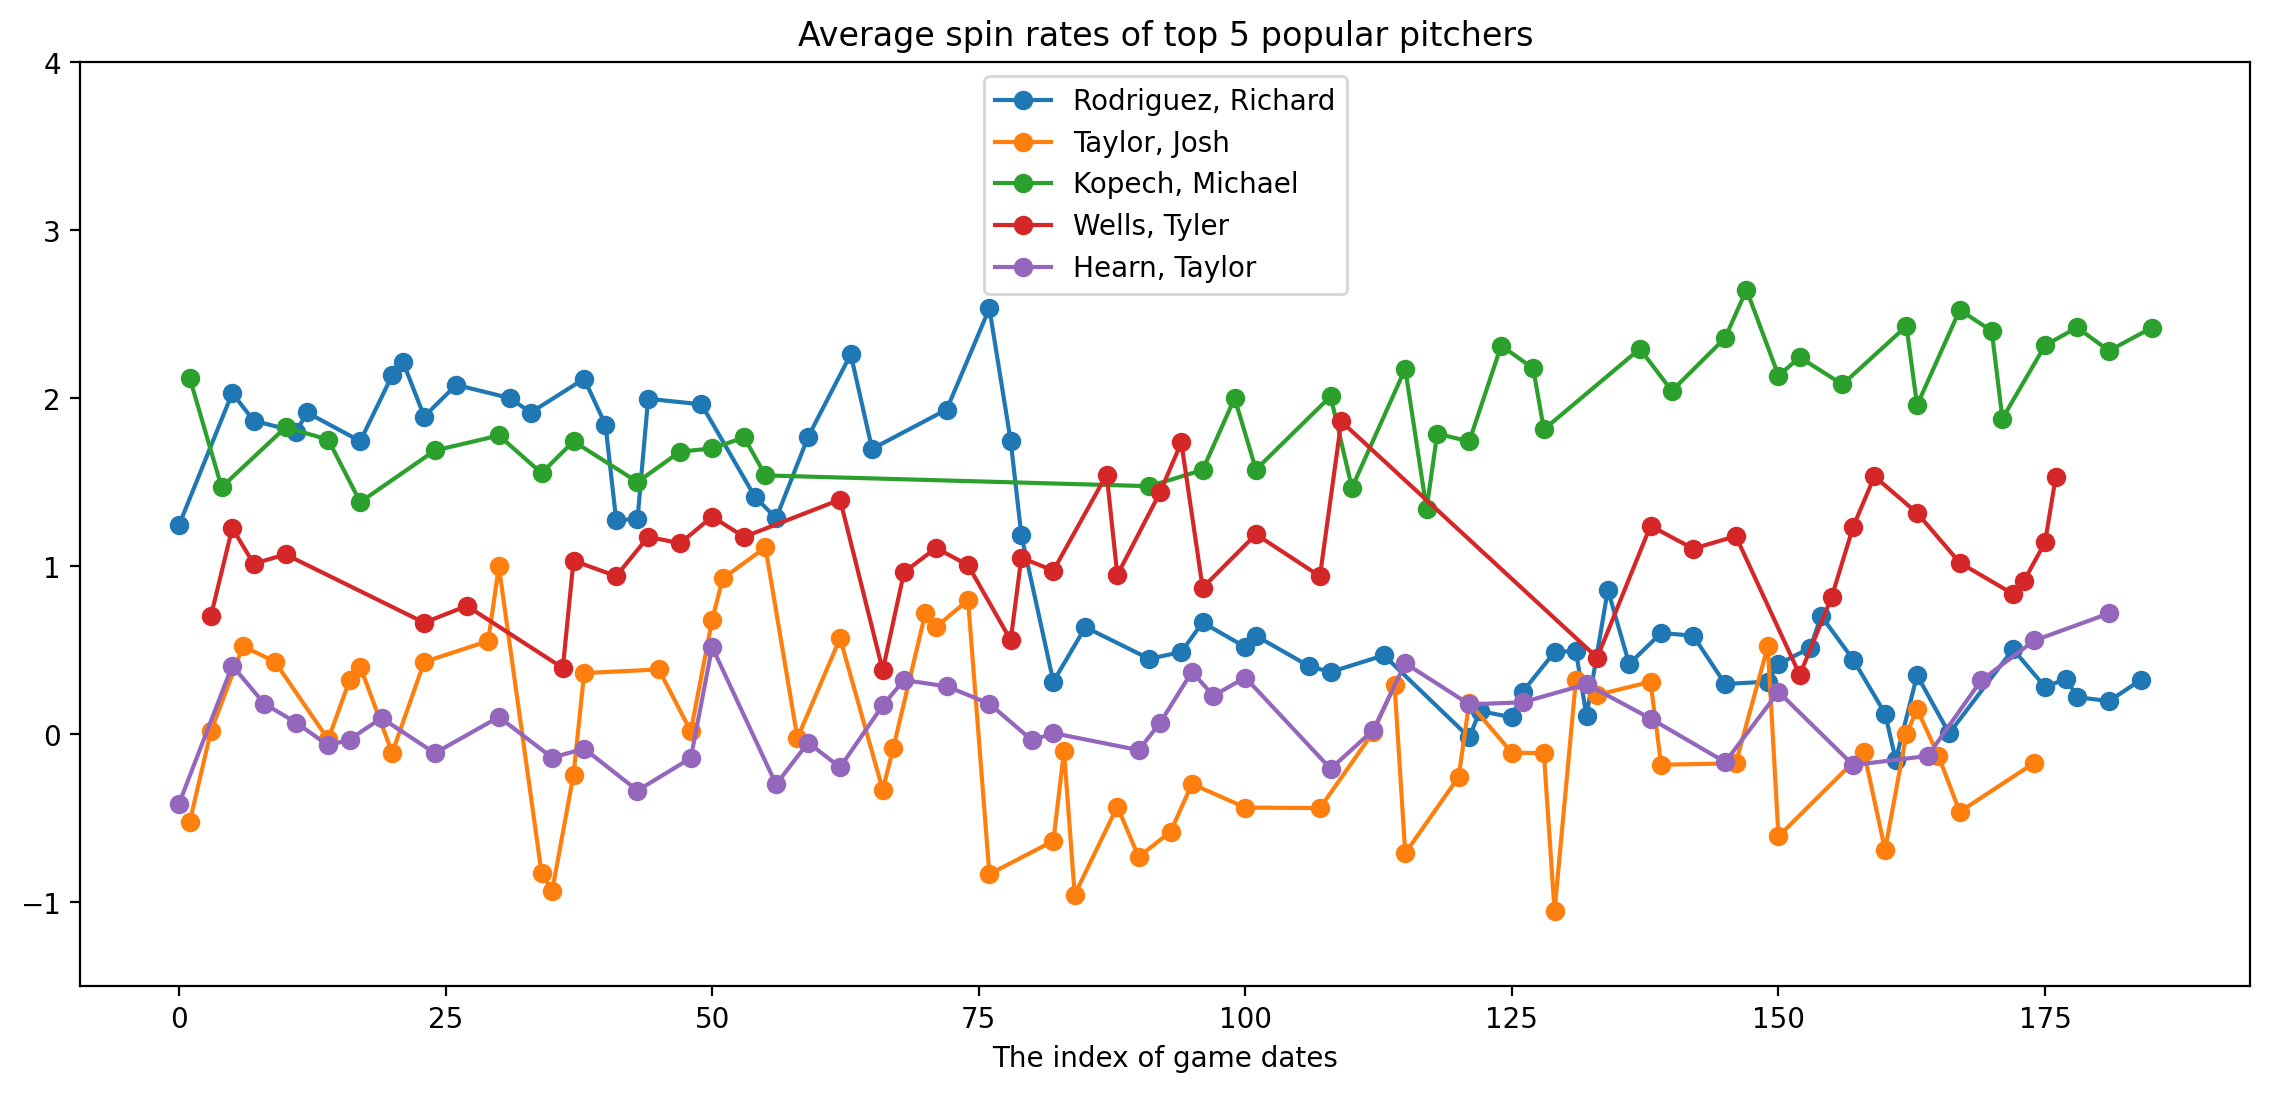

In [48]:
# Plot average spin rates of top pitchers
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
legends = []
for pitcher in top_pitchers["pitcher_name"]:
    cond = adf["pitcher_name"] == pitcher
    ax.plot(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"], "-o")
    legends.append(pitcher)
plt.title("Average spin rates of top 5 popular pitchers")
plt.xlabel("The index of game dates")
plt.ylim([-1.5, 4.0])
plt.legend(legends, loc="upper center");

## Intrinsic Coregionalization Model (ICM)

The Intrinsic Coregionalization Model (ICM) is a particular case of the Linear Coregionalization Model (LCM) with one input kernel, for example:

$$ K_{ICM} = B \otimes K_{ExpQuad} $$

Where $B(o,o')$ is the output kernel, and $K_{ExpQuad}(x,x')$ is an input kernel.

$$ B = WW^T +  diag(kappa) $$

In [49]:
def get_icm(input_dim, kernel, W=None, kappa=None, B=None, active_dims=None):
    """
    This function generates an ICM kernel from an input kernel and a Coregion kernel.
    """
    coreg = pm.gp.cov.Coregion(input_dim=input_dim, W=W, kappa=kappa, B=B, active_dims=active_dims)
    icm_cov = kernel * coreg  # Use Hadamard Product for separate inputs
    return icm_cov

In [50]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    kernel = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    sigma = pm.HalfNormal("sigma", sigma=3)

    # Get the ICM kernel
    W = pm.Normal("W", mu=0, sigma=3, shape=(n_outputs, 2), initval=np.random.randn(n_outputs, 2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=n_outputs)
    B = pm.Deterministic("B", pt.dot(W, W.T) + pt.diag(kappa))
    cov_icm = get_icm(input_dim=2, kernel=kernel, B=B, active_dims=[1])

    # Define a Multi-output GP
    mogp = pm.gp.Marginal(cov_func=cov_icm)
    y_ = mogp.marginal_likelihood("f", X, Y, sigma=sigma)

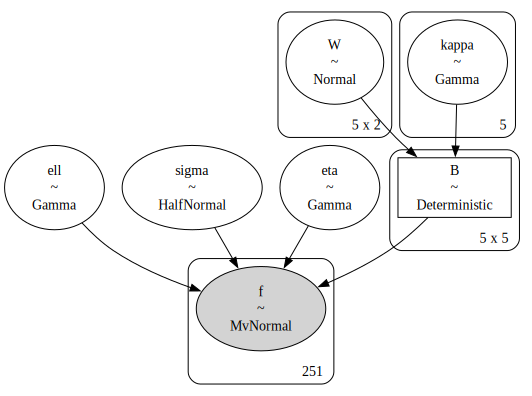

In [51]:
pm.model_to_graphviz(model)

In [ ]:
%%time
with model:
    gp_trace = pm.sample(2000, chains=1)
gp_trace

#### Prediction

In [32]:
# Prepare test data
M = 200  # number of data points
x_new = np.linspace(0, 200, M)[
    :, None
]  # Select 200 days (185 previous days, and add 15 days into the future).
X_new = np.vstack([x_new for idx in range(n_outputs)])
output_idx = np.vstack([np.repeat(idx, M)[:, None] for idx in range(n_outputs)])
X_new = np.hstack([X_new, output_idx])

In [53]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=["preds"], random_seed=42)

In [ ]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)


def plot_predictive_posteriors(f_pred, top_pitchers, M, X_new):
    fig, axes = plt.subplots(n_outputs, 1, figsize=(12, 15))

    for idx, pitcher in enumerate(top_pitchers["pitcher_name"]):
        # Prediction
        plot_gp_dist(
            axes[idx],
            f_pred[:, M * idx : M * (idx + 1)],
            X_new[M * idx : M * (idx + 1), 0],
            palette="Blues",
            fill_alpha=0.1,
            samples_alpha=0.1,
        )
        # Training data points
        cond = adf["pitcher_name"] == pitcher
        axes[idx].scatter(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"], color="r")
        axes[idx].set_title(pitcher)
    plt.tight_layout()


plot_predictive_posteriors(f_pred, top_pitchers, M, X_new)

NameError: name 'gp_samples' is not defined

It can be seen that the average spin rate of Rodriguez Richard decreases significantly from the 75th game dates. Besides, Kopech Michael's performance improves after a break of several weeks in the middle, while Hearn Taylor has performed better recently.

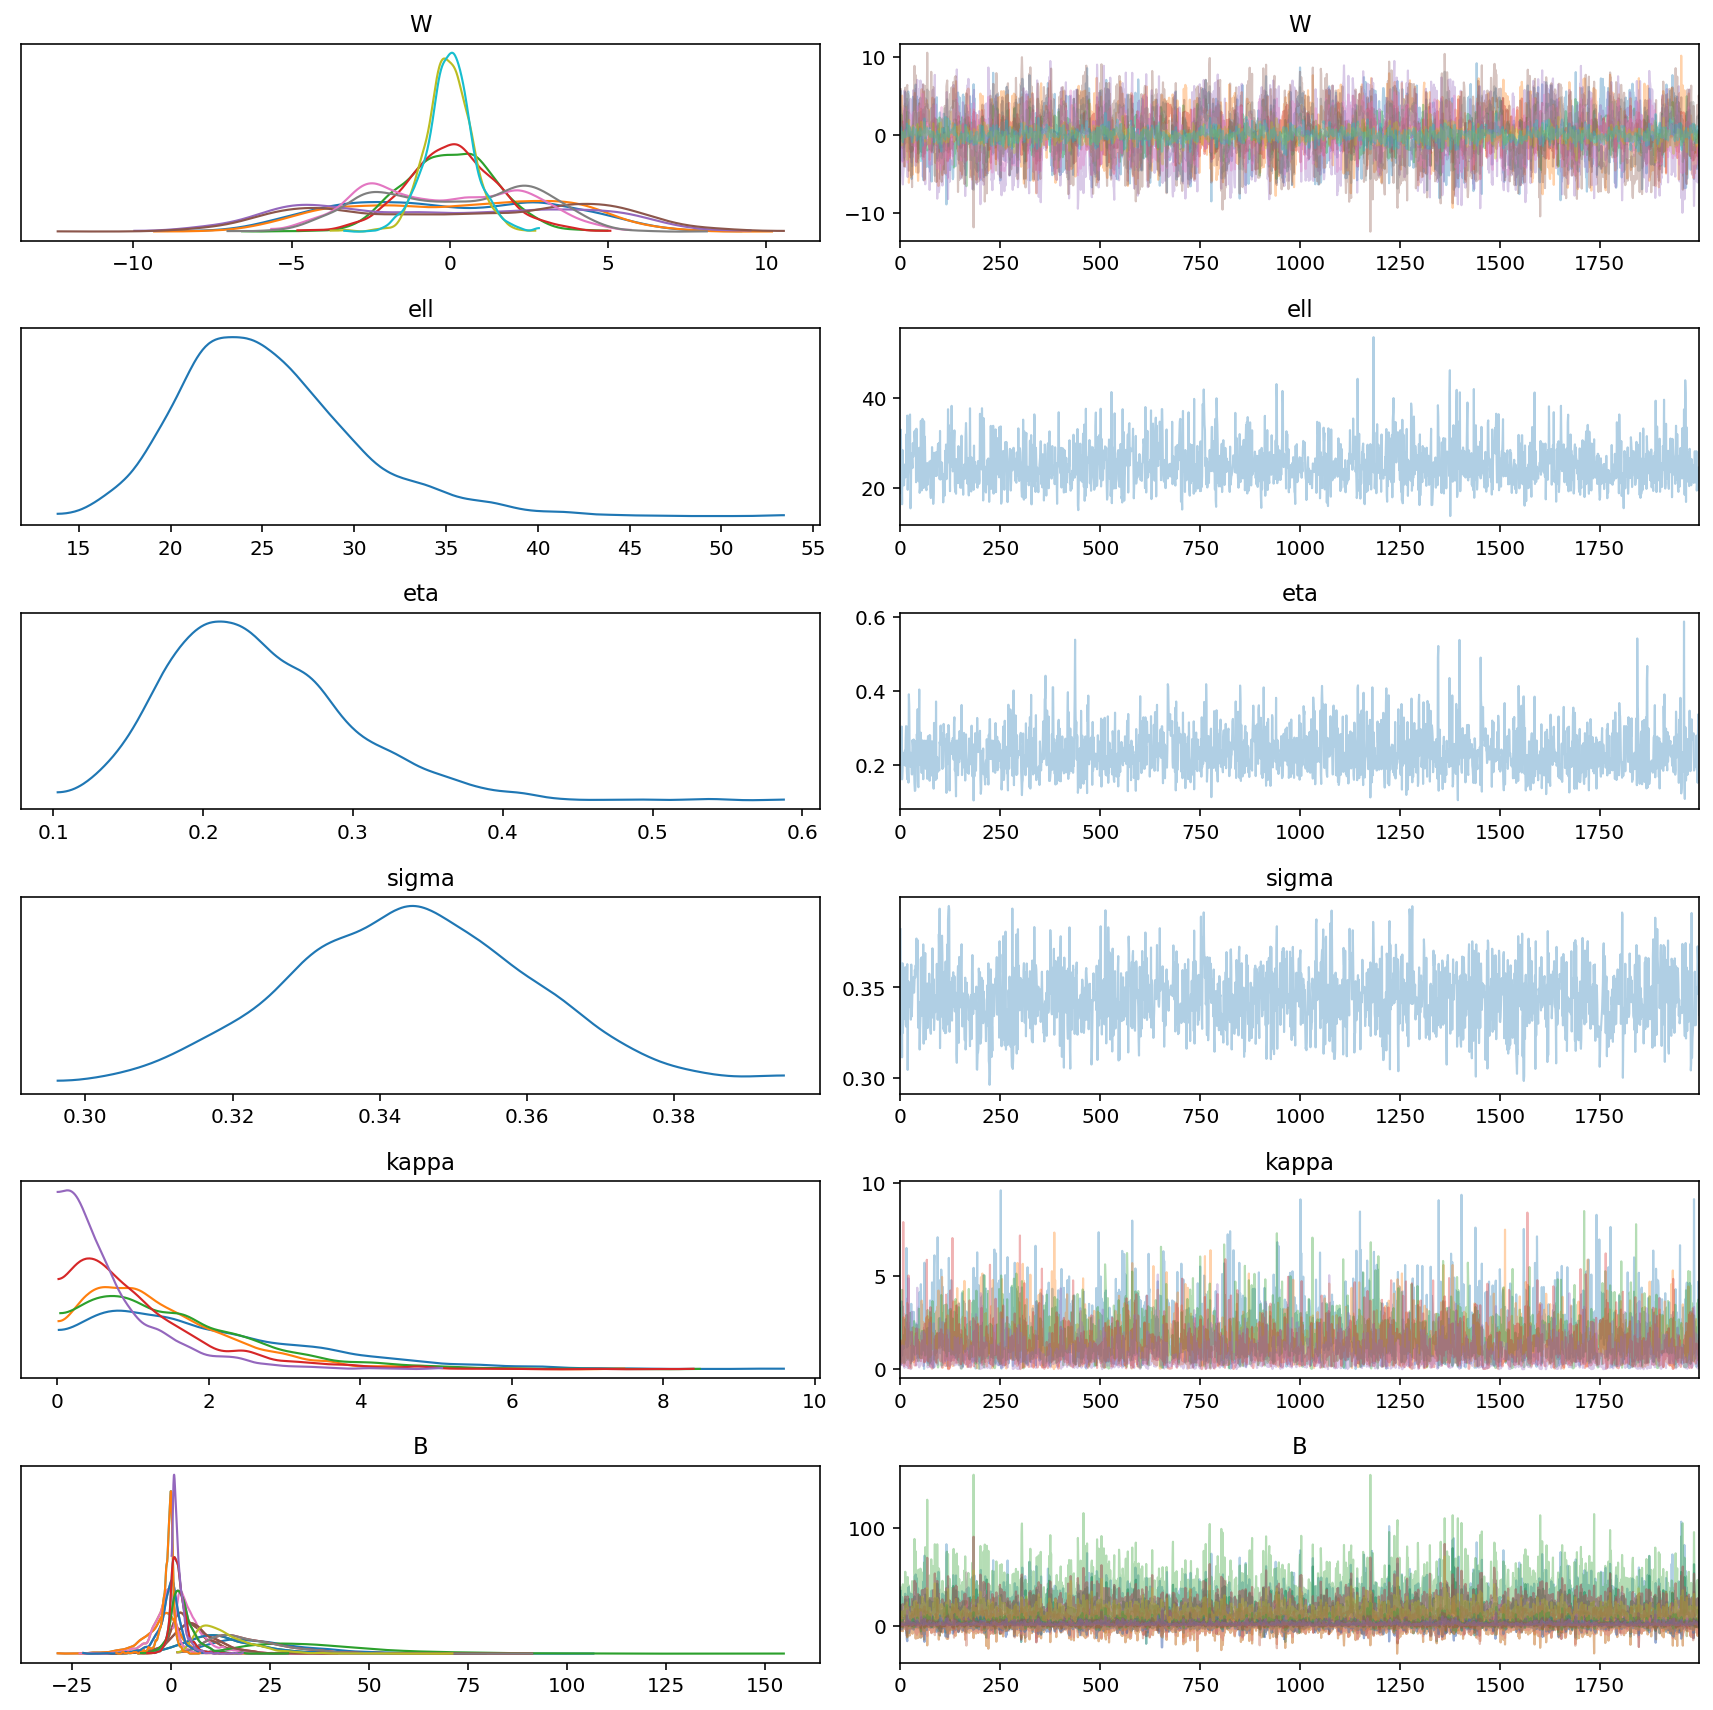

In [ ]:
az.plot_trace(gp_trace)
plt.tight_layout()

## Linear Coregionalization Model (LCM)

The LCM is a generalization of the ICM with two or more input kernels, so the LCM kernel is basically a sum of several ICM kernels. The LMC allows several independent samples from GPs with different covariances (kernels).

In this example, in addition to an `ExpQuad` kernel, we add a `Matern32` kernel for input data.

$$ K_{LCM} = B \otimes K_{ExpQuad} + B \otimes K_{Matern32} $$

In [ ]:
def get_lcm(input_dim, active_dims, num_outputs, kernels, W=None, B=None, name="ICM"):
    """
    This function generates a LCM kernel from a list of input `kernels` and a Coregion kernel.
    """
    if B is None:
        kappa = pm.Gamma(f"{name}_kappa", alpha=5, beta=1, shape=num_outputs)
        if W is None:
            W = pm.Normal(
                f"{name}_W",
                mu=0,
                sigma=5,
                shape=(num_outputs, 1),
                initval=np.random.randn(num_outputs, 1),
            )
    else:
        kappa = None

    cov_func = 0
    for idx, kernel in enumerate(kernels):
        icm = get_icm(input_dim, kernel, W, kappa, B, active_dims)
        cov_func += icm
    return cov_func

In [ ]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)

    # Define a list of covariance functions
    cov_list = [
        eta[idx] ** 2 * kernel(input_dim=2, ls=ell[idx], active_dims=[0])
        for idx, kernel in enumerate(kernels)
    ]

    # Get the LCM kernel
    cov_lcm = get_lcm(input_dim=2, active_dims=[1], num_outputs=n_outputs, kernels=cov_list)

    # Define a Multi-output GP
    mogp = pm.gp.Marginal(cov_func=cov_lcm)
    y_ = mogp.marginal_likelihood("f", X, Y, sigma=sigma)

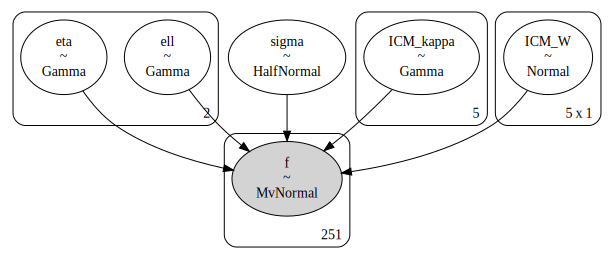

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
%%time
with model:
    gp_trace = pm.sample(2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_kappa, ICM_W]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 1109 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 40min 37s, sys: 1h 47min 9s, total: 2h 27min 46s
Wall time: 18min 39s


### Prediction

In [ ]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=["preds"], random_seed=42)

Sampling: [preds]


CPU times: user 51min 44s, sys: 50min 14s, total: 1h 41min 59s
Wall time: 12min 53s


In [ ]:
plot_predictive_posteriors(f_pred, top_pitchers, M, X_new)

NameError: name 'plot_predictive_posteriors' is not defined

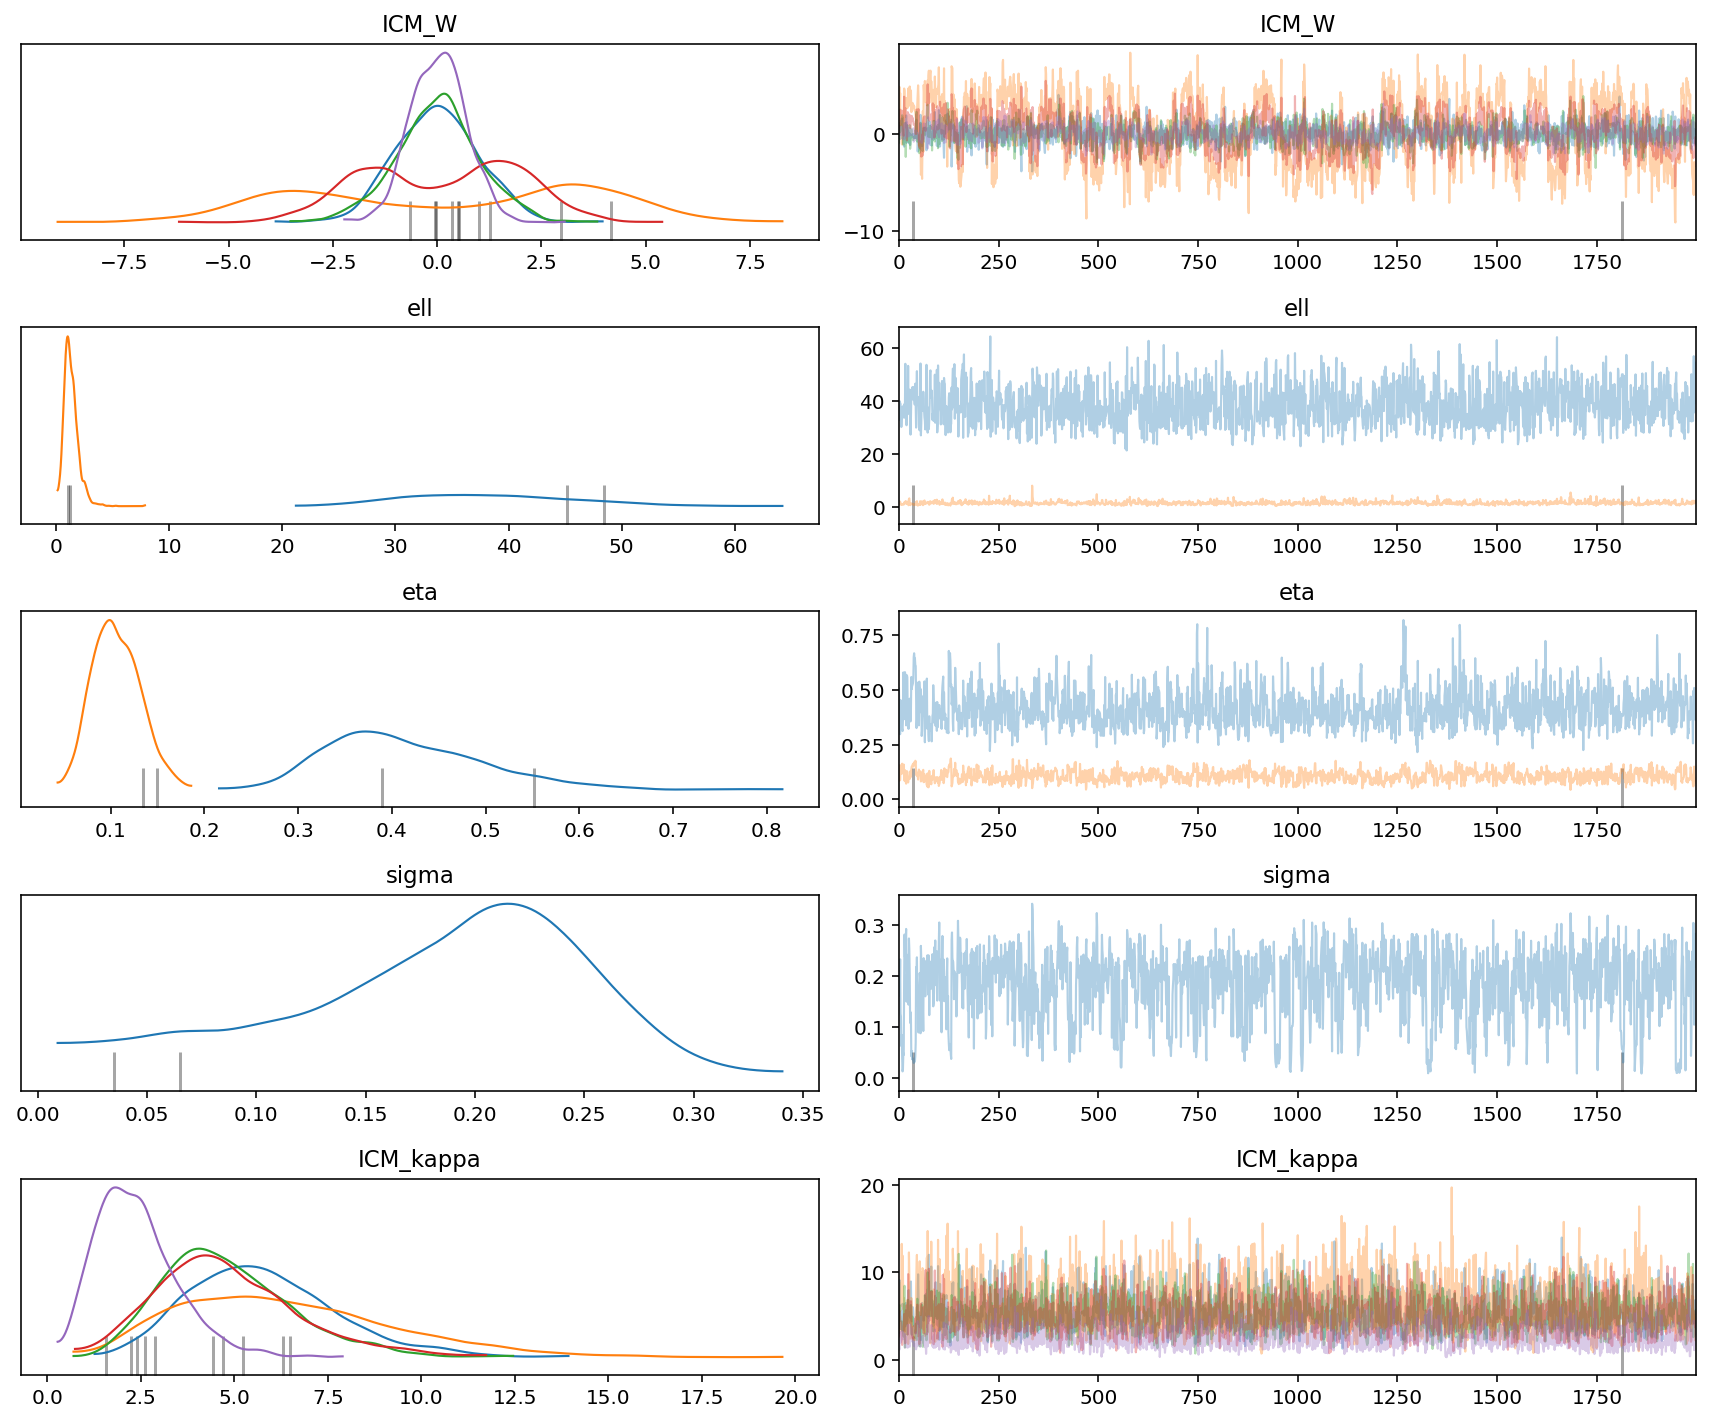

In [ ]:
az.plot_trace(gp_trace)
plt.tight_layout()

## Acknowledgement
This work is supported by 2022 [Google Summer of Codes](https://summerofcode.withgoogle.com/) and [NUMFOCUS](https://numfocus.org/).

## Authors
* Authored by [Danh Phan](https://github.com/danhphan), [Bill Engels](https://github.com/bwengals), [Chris Fonnesbeck](https://github.com/fonnesbeck) in November, 2022 ([pymc-examples#454](https://github.com/pymc-devs/pymc-examples/pull/454))

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Nov 12 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

pytensor: 2.8.6
aeppl : 0.0.36
xarray: 2022.3.0

pymc      : 4.2.1
arviz     : 0.13.0
pandas    : 1.4.2
pytensor    : 2.8.6
numpy     : 1.22.4
matplotlib: 3.5.2

Watermark: 2.3.0



:::{include} ../page_footer.md
:::